# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 5 minutes

This notebooks outlines the process of generating unbiased candidate mechanisms and comparing them to the dogmatic mechanisms from the [NeuroMMSig Knowledge Base](http://neurommsig.scai.fraunhofer.de/).

### Notebook Imports

In [1]:
import logging
import itertools as itt
import os
import time
from collections import defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2

import pybel
import pybel_tools as pbt
from pybel.canonicalize import calculate_canonical_name
from pybel.constants import *
from pybel_tools.visualization import to_jupyter

In [2]:
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packegs used are displayed explicitly.

In [3]:
time.asctime()

'Sun Aug 27 12:16:43 2017'

In [4]:
# seed the random number generator
import random
random.seed(127)

In [5]:
pybel.__version__

'0.7.3-dev'

In [6]:
pbt.__version__

'0.2.2-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease knowledge assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [8]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers', 'alzheimers.gpickle')

In [9]:
graph = pybel.from_pickle(pickle_path)

In [10]:
graph.version

'4.0.3'

## Summary of Subgraphs and Biological Processes

The unique values for the subgraph annotation are extracted and counted.

In [11]:
subgraph_names = sorted(pbt.summary.get_annotation_values(graph, 'Subgraph'))

In [12]:
len(subgraph_names)

128

The biological process nodes are retrieved with [pbt.filters.get_nodes_by_function](http://pybel-tools.readthedocs.io/en/latest/filters.html#pybel_tools.filters.get_nodes_by_function) and counted.

In [13]:
bioprocess_nodes = sorted(pbt.filters.get_nodes_by_function(graph, BIOPROCESS))

In [14]:
len(bioprocess_nodes)

401

The BEL graph object is split to multiple BEL graph objects representing each of the subgraphs with [pbt.selection.get_subgraphs_by_annotation](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_subgraphs_by_annotation).

In [15]:
subgraphs = pbt.selection.get_subgraphs_by_annotation(graph, 'Subgraph')

### Biological Processes and Dogmatic Subgraphs

This section investigates the questions: which biological processess appear in multiple subgraphs, and which subgraphs contain multiple biological processes?

Asking which bioprocesses appear in multiple subgraphs allow us to investigate their upstream controllers. In a knowledge discovery scenario, this could provide evidence of cross-talk.

In [16]:
bp2sg = defaultdict(set)

for name, subgraph in subgraphs.items():
    for bp in pbt.filters.get_nodes_by_function(subgraph, BIOPROCESS):
        bp2sg[bp].add(name)
        
bp2sg = dict(bp2sg)

bp2sg_counts = pbt.utils.count_dict_values(bp2sg)

In [17]:
sg2bp = {
    name: set(pbt.filters.get_nodes_by_function(subgraph, BIOPROCESS))
    for name, subgraph in subgraphs.items()
}

sg2bp_counts = pbt.utils.count_dict_values(sg2bp)

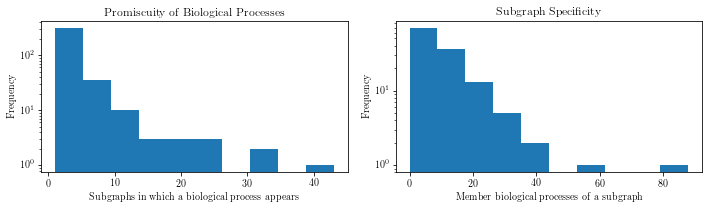

In [18]:
fig, (lax, rax), = plt.subplots(1, 2, figsize=(10, 3))

lax.set_title('Promiscuity of Biological Processes')
lax.set_ylabel('Frequency')
lax.set_xlabel('Subgraphs in which a biological process appears')
lax.hist(list(bp2sg_counts.values()), log=True)

rax.set_title('Subgraph Specificity')
rax.set_ylabel('Frequency')
rax.set_xlabel('Member biological processes of a subgraph')
rax.hist(list(sg2bp_counts.values()), log=True)

plt.tight_layout()
plt.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'sg_comparison.pdf'))
plt.show()


The top 25 most frequently biological processes are shown below.

In [19]:
for bp, count in bp2sg_counts.most_common(5):
    print('{:2} {:6} {}'.format(count, graph.node[bp][NAMESPACE], graph.node[bp][NAME]))

43 GOBP   apoptotic process
32 GOBP   neuron death
31 GOBP   neuron apoptotic process
26 GOBP   cell death
25 GOBP   cognition


The top 25 highest biological-process dense subgraphs are shown below.

In [20]:
for name, count in sg2bp_counts.most_common(5):
    print('{:2} {}'.format(count, name))

88 Amyloidogenic subgraph
58 Insulin signal transduction
43 Tau protein subgraph
39 Inflammatory response subgraph
35 Non-amyloidogenic subgraph


### Annotation Landscape

The landscape of biological processes' membership to dogmatic subgraphs is shown below.

The biological process to dogmatic subgraph membership matrix is calculated, clustered, and plotted below.

In [21]:
sg_bp_membership = defaultdict(dict)
sg_bp_membership_bool = defaultdict(dict)

for name, bp in itt.product(subgraph_names, bioprocess_nodes):
    sg_bp_membership_bool[name][bp] = bp in sg2bp[name]
    sg_bp_membership[name][bp] = 1 if bp in sg2bp[name] else 0
    
sg_bp_membership = dict(sg_bp_membership)
sg_bp_membership_bool = dict(sg_bp_membership_bool)

## Generated Unbiased Subgraphs

Each subgraph annotation in the NeuroMMSig Database comes from a specific domain of study. While these subgraphs attempt to describe groups of related, dogmatic pathways and are helpful for communicating ideas, they are a discretization of the continuous and inseperable biological system. In this section, we will generate more, smaller candidate subgraphs with an unbiased approach in hopes of providing a more thorough overview of the individual mechanisms in the hollistic system and their interplay or "cross-talk". Later, we'll use that information to assess the overlap between dogmatic mechanisms and bridge the gaps between them.

The candidate mechanisms themselves are generated with [pbt.generation.generate_bioprocess_mechanisms](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_bioprocess_mechanisms) by expanding to the upstream controllers around each biological process.

In [22]:
%%time
candidate_mechanisms = pbt.generation.generate_bioprocess_mechanisms(graph)

CPU times: user 2.9 s, sys: 50.1 ms, total: 2.95 s
Wall time: 2.97 s


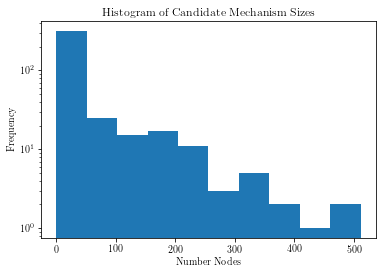

In [23]:
plt.title('Histogram of Candidate Mechanism Sizes')
plt.xlabel('Number Nodes')
plt.ylabel('Frequency')
plt.hist([cm.number_of_nodes() for cm in candidate_mechanisms.values()], log=True)
plt.show()

## Overlap Summary

The Tversky similarity is calculated between the nodes contained in each candidate mechanism versus each dogmatic subgraph. It is weighted to calculate what percentage of the nodes in a candidate mechanism with $\alpha=1$ and $\beta=0$.

In [24]:
%%time

sg_bp_overlap = defaultdict(dict)

for name, bp in itt.product(subgraphs, bioprocess_nodes):
    x = set(pbt.filters.get_nodes_by_function(candidate_mechanisms[bp], {PROTEIN, BIOPROCESS}))
    y = set(subgraphs[name].nodes_iter())
    
    sg_bp_overlap[name][bp] = pbt.utils.set_percentage(x, y)
    
sg_bp_overlap = dict(sg_bp_overlap)

CPU times: user 5.65 s, sys: 53.5 ms, total: 5.7 s
Wall time: 5.75 s


In [25]:
overlap_df = pd.DataFrame(sg_bp_overlap)
overlap_df.to_csv(os.path.expanduser('~/Desktop/subgraph_comparison.csv'))

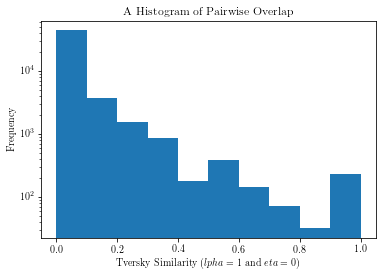

In [26]:
plt.title('A Histogram of Pairwise Overlap')
plt.xlabel('Tversky Similarity ($\alpha = 1$ and $\beta = 0$)')
plt.ylabel('Frequency')
plt.hist(overlap_df.as_matrix().ravel(), log=True)
plt.show()

The landscape of overlaps between unbiased candidate mechanisms and dogmatic subgraphs is shown below.

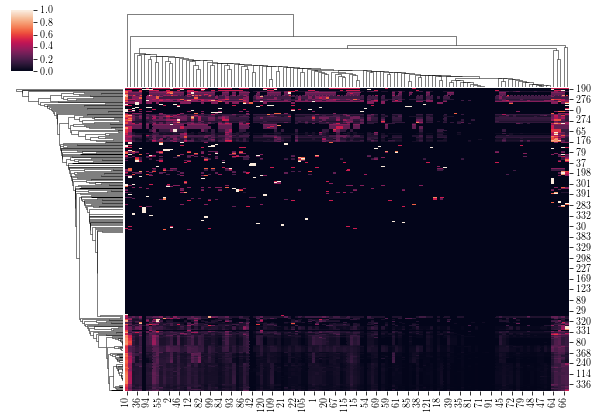

In [27]:
overlap_matrix = overlap_df.as_matrix()
cg = sns.clustermap(overlap_matrix, figsize=(10, 7))

In [28]:
plt.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'sg_overlaps.pdf'))
plt.show()

The overlap similarity matrix is discretized with a cutoff and displayed below.

In [29]:
overlap_cutoff = 0.3

In [30]:
overlap_matrix_discrete = overlap_cutoff < overlap_matrix

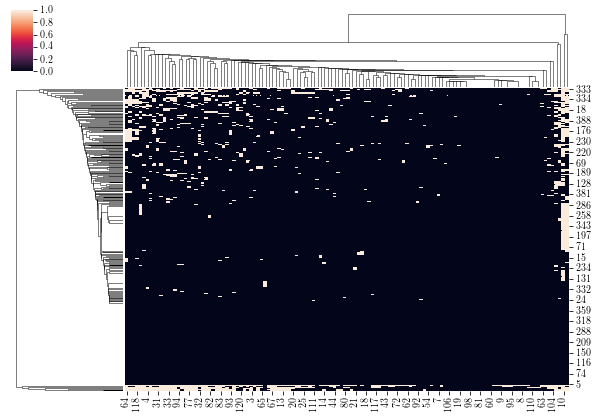

In [31]:
sns.clustermap(overlap_matrix_discrete , figsize=(10, 7))
plt.show()

## Concordance Calculations

Next, biological processes whose candidate mechanisms have significant overlap with dogmatic subgraphs are annotated to those subgraphs.

In [32]:
#: Keeps track of which biological processes have large overlap with a dogmatic mechanism, but wasn't in it
sg_added = {}
sg_bp_cutoff_member = defaultdict(dict)

for name in subgraph_names:
    sg_added[name] = set()
    for bp in bioprocess_nodes:
        
        concordance = overlap_cutoff < sg_bp_overlap[name][bp]
        
        sg_bp_cutoff_member[name][bp] = concordance
        
        if bp not in sg2bp[name] and concordance:
            sg_added[name].add(bp)

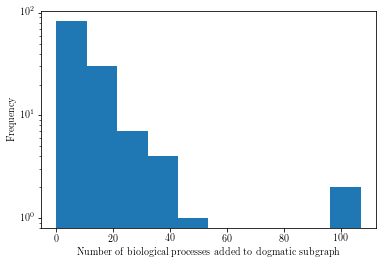

In [33]:
plt.xlabel('Number of biological processes added to dogmatic subgraph')
plt.ylabel('Frequency')
plt.hist([len(v) for v in sg_added.values()], log=True)
plt.show()

Similarity values between the set of added biological processes and the set of contained biological processes for each dogmatic mechanism are calculated. 

Higher similarity means that this approach has lower potential for asserting subgraph expansions, so the values are subtracted from one to preserve monotonicity and improve interpretability.

In [34]:
sg_concordance = {}

for name in subgraphs:
    x = sg_added[name]
    y = {bp for bp in bioprocess_nodes if sg_bp_cutoff_member[name][bp]}
    
    sg_concordance[name] = 1 - pbt.utils.tanimoto_set_similarity(x, y)

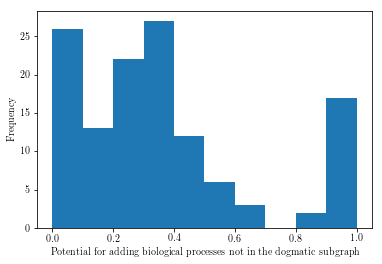

In [35]:
plt.ylabel('Frequency')
plt.xlabel('Potential for adding biological processes not in the dogmatic subgraph')
plt.hist(list(sg_concordance.values()))
plt.show()

The similarity values correspond to which dogmatic subgraphs have the highest potential for expansion, with higher values corresponding to higher potential.

In [36]:
for dm, concordance in sorted(sg_concordance.items(), key=itemgetter(1), reverse=True):
    print('{:.2f} {}'.format(concordance, dm))

1.00 Neurotransmitter release subgraph
1.00 Nucleoside salvage subgraph
1.00 Beta-Oxidation of Fatty Acids
1.00 Galanin subgraph
1.00 Myeloperoxidase subgraph
1.00 p53 stabilization subgraph
1.00 Smad subgraph
1.00 Glycolysis subgraph
1.00 Disaccharide metabolism subgraph
1.00 XIAP subgraph
1.00 RhoA subgraph
1.00 Protein biosynthesis subgraph
1.00 Protein degradation subgraph
1.00 Dopaminergic subgraph
1.00 Alcohol dehydrogenase subgraph
1.00 LRRK2 subgraph
1.00 Syndecan subgraph
0.83 Blood vessel dilation subgraph
0.83 Serotonergic subgraph
0.67 Reelin signaling subgraph
0.67 KANSL1 subgraph
0.67 CREB subgraph
0.60 DKK1 subgraph
0.50 Low density lipoprotein subgraph
0.50 Metabolism of steroid hormones subgraph
0.50 Retinoblastoma subgraph
0.50 Cell-cell communication subgraph
0.50 Vitamin subgraph
0.48 Tau protein subgraph
0.47 Unfolded protein response subgraph
0.45 Synaptic vesicle endocytosis subgraph
0.44 Electron transport chain
0.44 Phosphatidylinositol 3 subgraph
0.43 Immunogl

# Conclusions

Generating unbiased candidate mechanism subgraphs ultimately provides similar insight as painstakingly curated subgraphs. It is also possible to identify high novelty in candidate mechanisms that have little overlap with curated subgraphs and high scores in data driven approaches.